#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

##  Loading data

In [2]:
# Reading source data.
training_data = pd.read_csv('training.csv')

In [3]:
#Images are stored as string. We convert them to a np array. 

images = training_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))
images = np.vstack([images.iloc[i] for i in range(len(images))])

In [4]:
#Creating keypoints dataframe. 
keypoints = training_data.drop('Image', axis = 1)

## Data augmentation: Including reflected pictures into the dataset

In order to increase our dataset I will reflect all images left to right, and add them as different images.

This implies flipping the images, and reflecting all x-coordinates of the keypoints such that $x_{reflected} = 95 - x_{old}$.


In [5]:
# building an array of reflected images.
flipped_ims = np.zeros(images.shape)
for j in range(images.shape[0]):
    for i in range(96):
        flipped_ims[j,i*96:(i+1)*96] = np.flip(images[j,i*96:(i+1)*96])

In [6]:
# adding the reflected images to our images array. 
# RUN THIS CELL ONLY ONCE. 
images = np.vstack((images, flipped_ims))

In [7]:
# Now the keypoints. I need to switch left and right features, 
# and reflect the x coordinates by x --> 95-x (95 is the last coordinate of the picture. )

reflected_keypoints = pd.DataFrame(columns = keypoints.columns)

# We look for the correspoding columns by switching 'left' <--> 'right'.
for colname in reflected_keypoints.columns:
    if 'left' in colname:
        reference_col = colname.replace('left', 'right')
    elif 'right' in colname:
        reference_col = colname.replace('right','left')
    else:
        reference_col = colname
        
    # Assigning values and reflecting x coordinates
    # reflected_keypoints[colname] = keypoints[reference_col].apply(lambda x: 95-x if colname[-1]=='x' else x)
    # the one-line version is fine but I think separating is more readable.
    
    reflected_keypoints[colname] = keypoints[reference_col]
    if colname[-1] == 'x':
        reflected_keypoints[colname] = reflected_keypoints[colname].apply(lambda x: 95-x)   

In [8]:
# Adding reflected keypoints to the original keypoints. 
# RUN THIS CELL ONLY ONCE.
keypoints = pd.concat([keypoints,reflected_keypoints], ignore_index=True)

## Perform a train_test_split in order to have a cross validation set. 

In [9]:
x_train, x_cv, keypoints_train, keypoints_cv = train_test_split(images, keypoints, 
                                                                test_size=100, random_state = 42)

In [10]:
# BASELINE
# As a guide, we compute the error on the cv set obtained by using the mean position of
# each keypoint.

mean_keypoints = keypoints_train.mean()
baseline_rmse = np.sqrt(((keypoints_cv - mean_keypoints)**2).mean().mean())

print('Using the mean poistion the RMSE on the cv set is: ', baseline_rmse)

Using the mean poistion the RMSE on the cv set is:  3.1721240528361268


A good estimation should improve on this result. 

##  Define a function for taking random batches. 

In [11]:
def next_batch(X, labels, batch_size):
    """ A function for generating training batches. 
    X = Collection of examples.
    labels = True labels. 
    batch_size = Number of elements to be randomly selected. """
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    images = X[sample_indices]
    keypoints = labels.iloc[sample_indices]
        
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [12]:
# Wrappers of tensorflow methods. This functions will help make
# the construction of the network more straightforward. 

def init_weights(shape):
    init_random_dist = tf.initializers.random_normal(stddev=0.1)
    #init_random_dist = tf.initializers.he_normal()
    return tf.get_variable('weights', shape=shape ,initializer= init_random_dist)

def init_bias(shape):
    #init_bias_vals = tf.random_uniform(shape=shape)
    init_bias_vals = tf.initializers.random_uniform()
    return tf.get_variable('bias', shape = shape ,initializer= init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

def output_act_function(input_layer):
    factor = tf.constant(96, dtype = tf.float32)
    return tf.multiply(factor, tf.nn.sigmoid(input_layer))

def sigmoid_layer(input_layer, size, max_val):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    factor = tf.constant(max_val, dtype = tf.float32)
    return tf.multiply(factor, tf.nn.sigmoid(tf.matmul(input_layer, W) + b))
    

def new_bn_layer(input_x, training, decay = 0.999):
    """ Wrapper function for tf.contrib.layers.batch_norm """
    
    return tf.contrib.layers.batch_norm(input_x, decay = decay, is_training = training  )

# Building the network

In [126]:
tf.reset_default_graph()

In [127]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216], name = 'images')
keypoints_true = tf.placeholder(tf.float32, [None, 30], name = 'true_keypoints')
lr = tf.placeholder(tf.float32, name = 'learning_rate')
#training = tf.placeholder(tf.bool, name='training_state')
drop_rate = tf.placeholder(tf.float32, name = 'dropout_prob')

In [128]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

In [129]:
# LAYERS

with tf.variable_scope('Convo1'):
    convo1 = convolutional_layer(x_images, [6,6,1,32]) # 6 x 6 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

    convo1_pool = tf.nn.max_pool(convo1, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')   #output of 24 x 24 x 32
        
with tf.variable_scope('Convo2'):    
    convo2 = convolutional_layer(convo1_pool, [2,2,32,64]) # 4x4 filter, 64 outputs. SAME padding.

    convo2_pool = max_pool_2by2(convo2) # 12 x 12 x64
    
            
with tf.variable_scope('Convo3'):
    convo3 = convolutional_layer(convo2_pool, [2,2,64,128]) # 2x2 filter, 128 outputs. SAME padding.

    convo3_pool = max_pool_2by2(convo3) # 6 x 6 x 128

    convo3_flat = tf.reshape(convo3_pool,[-1,6*6*128])
    
with tf.variable_scope('Full_one'):
    
    full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))
    
        
# DROPOUT 

full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_rate)

# OUTPUT LAYER
with tf.variable_scope('Output'):
    
    keypoints_pred = normal_full_layer(full_one_dropout,30)
    

In [130]:
# LOSS FUNCTION
with tf.variable_scope('Loss'):
    masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred - keypoints_true, tf.is_finite(keypoints_true) ) ) ) 
                                 

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)

    train = optimizer.minimize(masked_loss)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [131]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [132]:
counter = 7 # a variable to keep track of different models.

## Training

Currently on step 10000
Train MSE:  5.31149 

CV MSE: 3.845327 

train_losses =  [3895.7373, 53.761875, 40.32972, 55.883698, 29.975763, 27.427702, 27.787798, 19.477526, 17.355087, 19.739178, 17.201523, 26.481224, 22.375923, 20.975775, 16.248653, 16.027792, 15.242113, 11.913187, 14.256994, 14.045681, 15.990785, 12.402939, 10.854957, 48.677048, 10.484851, 15.473874, 16.373646, 10.698612, 9.090241, 10.065947, 11.900505, 13.312194, 10.485497, 10.221558, 10.141301, 11.797573, 12.04387, 10.686767, 12.551306, 12.980504, 14.439675, 7.0825953, 8.154166, 13.426133, 18.860271, 11.520527, 7.490215, 9.880398, 10.809783, 8.183197, 17.248283, 16.134968, 7.2732363, 8.296272, 18.671486, 7.5074425, 13.403136, 9.760057, 8.011375, 14.441729, 12.362705, 9.131661, 12.073082, 7.1840515, 7.613679, 8.140977, 12.536511, 6.376635, 5.510159, 6.001378, 10.359046, 7.4619927, 7.5777173, 7.3045135, 8.84355, 5.824926, 10.930714, 7.0464177, 9.480195, 6.19357, 6.7502193, 9.024692, 6.362078, 6.780737, 4.433567, 11.310039

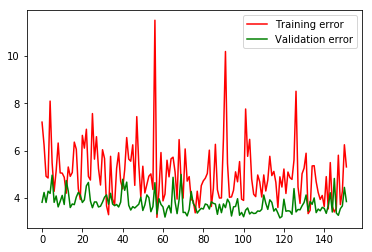

In [137]:
num_steps = 10000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    
    writer = tf.summary.FileWriter('./tensorboard_logs', sess.graph)
    #sess.run(init)
    saver.restore(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    
    #train_losses = []
    #cv_losses = []
    
    
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train,32)
        
        
        # Uncomment for BN
        _ , train_loss= sess.run([train, masked_loss], 
                             feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                        lr:0.0005, drop_rate:0.2})
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss,
                               feed_dict={x:x_cv, keypoints_true:keypoints_cv, drop_rate:0})
            
            #I plot MSE because it is a bit easier to visualize. Small changes are larger. 
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
            
            #train_losses.append(np.sqrt(train_loss))
            #cv_losses.append(np.sqrt(cv_loss))
                        
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss)
            print('Train RMSE: ', np.sqrt(train_loss), '\n')
            print('CV MSE:', cv_loss)
            print('CV RMSE:', np.sqrt(cv_loss), '\n')
            
            ax.cla()
            ax.plot(train_losses[150:], 'r', label = 'Training error')
            ax.plot(cv_losses[150:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            #print('train_losses = ', train_losses, '\n')
            #print('cv_losses = ', cv_losses)
            
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_losses[-1], '\n')
    print('CV MSE:',  cv_losses[-1], '\n')

    ax.cla()
    ax.plot(train_losses[150:], 'r', label = 'Training error')
    ax.plot(cv_losses[150:], 'g', label = 'Validation error')
    ax.legend()
    
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    saver.save(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    writer.close()
    #saver.save(sess, "./saved_models/keypoints_cnn_1"  )
    #counter +=1
    #print(counter)

In [141]:
print('train_losses = ', train_losses)
print('cv_losses = ', cv_losses)

train_losses =  [3895.7373, 53.761875, 40.32972, 55.883698, 29.975763, 27.427702, 27.787798, 19.477526, 17.355087, 19.739178, 17.201523, 26.481224, 22.375923, 20.975775, 16.248653, 16.027792, 15.242113, 11.913187, 14.256994, 14.045681, 15.990785, 12.402939, 10.854957, 48.677048, 10.484851, 15.473874, 16.373646, 10.698612, 9.090241, 10.065947, 11.900505, 13.312194, 10.485497, 10.221558, 10.141301, 11.797573, 12.04387, 10.686767, 12.551306, 12.980504, 14.439675, 7.0825953, 8.154166, 13.426133, 18.860271, 11.520527, 7.490215, 9.880398, 10.809783, 8.183197, 17.248283, 16.134968, 7.2732363, 8.296272, 18.671486, 7.5074425, 13.403136, 9.760057, 8.011375, 14.441729, 12.362705, 9.131661, 12.073082, 7.1840515, 7.613679, 8.140977, 12.536511, 6.376635, 5.510159, 6.001378, 10.359046, 7.4619927, 7.5777173, 7.3045135, 8.84355, 5.824926, 10.930714, 7.0464177, 9.480195, 6.19357, 6.7502193, 9.024692, 6.362078, 6.780737, 4.433567, 11.310039, 6.909489, 5.3054786, 6.9956694, 6.784847, 5.7878923, 6.368308, 

In [144]:
np.mean(np.sqrt(cv_losses[-30:]))

1.9185755

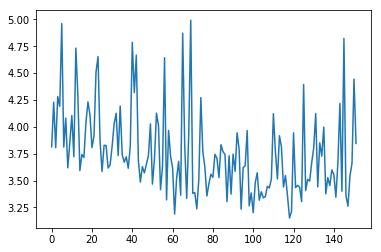

In [138]:
plt.plot(cv_losses[150:])

In [139]:
np.mean(np.sqrt(train_losses)[-5:])

2.2424266

Text(0.5, 1.0, 'RMSE')

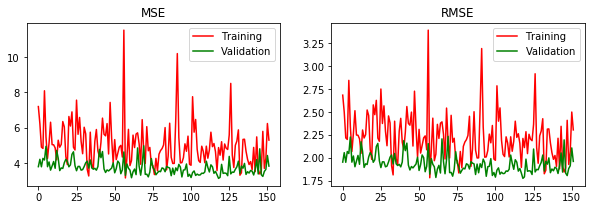

In [140]:
figure, ax = plt.subplots(1,2, figsize = (10,3))

from_step = 150

ax[0].plot(train_losses[from_step:], 'r', label = 'Training')
ax[0].plot(cv_losses[from_step:], 'g', label = 'Validation')
ax[0].legend()
ax[0].set_title('MSE')

ax[1].plot(np.sqrt(train_losses[from_step:]), 'r', label = 'Training')
ax[1].plot(np.sqrt(cv_losses[from_step:]), 'g', label = 'Validation')
ax[1].legend()
ax[1].set_title('RMSE')




## Predictions for the cv set

In [145]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_cnn_" + str(counter))

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions, loss = sess.run([keypoints_pred, masked_loss], feed_dict= {x:x_cv, keypoints_true:keypoints_cv, 
                                                                          drop_rate:0 })
    

INFO:tensorflow:Restoring parameters from ./saved_models/keypoints_cnn_7


In [146]:
np.sqrt(loss)

1.9609505

In [147]:
predictions.shape

(100, 30)

In [148]:
np.max(predictions)

91.630325

In [149]:
np.unravel_index( np.argmax(predictions), predictions.shape)

(73, 29)

In [ ]:
predictions[73,29]

In [ ]:
x_cv.shape

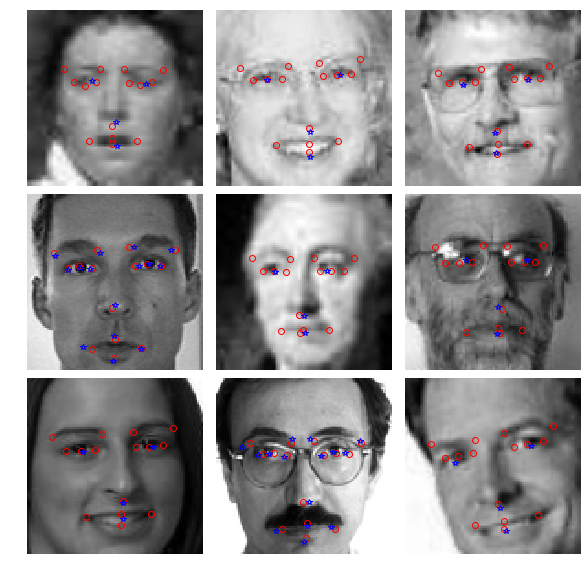

In [150]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(x_cv)), size = grid_size**2, )

mean_x_points = [mean_keypoints[j] for j in range(0,30,2)]
mean_y_points = [mean_keypoints[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  
 # Plotting true keypoints
    
    x_true = [keypoints_cv.iloc[i][j] for j in range(0,30,2)]
    y_true = [keypoints_cv.iloc[i][j+1] for j in range(0,30,2)]
    
    ax.plot(x_true, y_true, 'b*', markerfacecolor = 'none')    
    
 # Including mean keypoints
       
    #ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  

## Predictions for the test set

In [151]:
test_data = pd.read_csv('test.csv')
test_data.shape

(1783, 2)

In [152]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [153]:
test_images = test_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

test_images = np.vstack([test_images.iloc[i] for i in range(len(test_images))])

In [154]:
saver = tf.train.Saver()

In [155]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_cnn_" + str(counter))
    
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:test_images, drop_rate:0 })
    

INFO:tensorflow:Restoring parameters from ./saved_models/keypoints_cnn_7


In [156]:
predictions.shape

(1783, 30)

In [157]:
np.where(predictions >= 96)

(array([], dtype=int64), array([], dtype=int64))

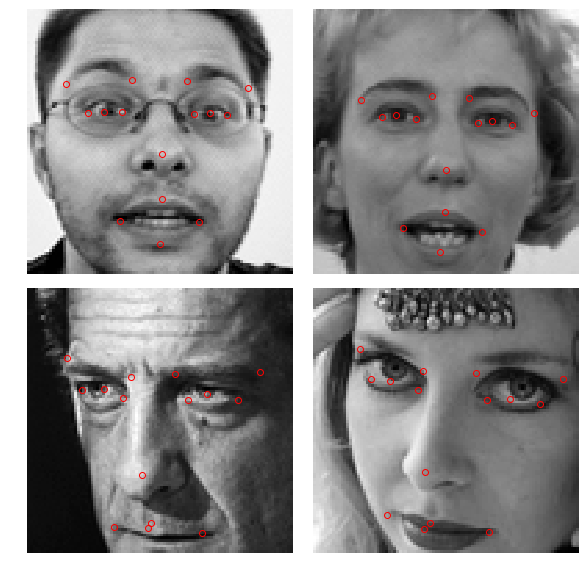

In [158]:
grid_size = 2
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

#selection = np.random.choice(range(len(test_images)), size = grid_size**2 )
selection = [0, 175, 491, 1474]
for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(test_images[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    

## Make a dataframe with predictions

In [159]:
predicted_keypoints = pd.DataFrame(data = predictions, columns = keypoints.columns)

In [160]:
predicted_keypoints[(predicted_keypoints>96).any(1)]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y


In [161]:
predicted_keypoints.to_csv('full_test_predictions_002.csv')

## Loading the lookup table to make a submission file. 

In [162]:
lookup_table = pd.read_csv('IdLookupTable.csv', header = 0, index_col = 'RowId')

In [163]:
locations_list = []
for i in lookup_table.iterrows():
    position = predicted_keypoints.iloc[i[1]['ImageId']-1][i[1]['FeatureName']]
    locations_list.append(position)
len(locations_list)

27124

In [164]:
#empty dataframe for testing submission
Submission_df = pd.DataFrame(columns = ['Location'], index = lookup_table.index)

In [165]:
Submission_df['Location'] = locations_list

In [166]:
Submission_df.to_csv('submission_004.csv')